## 0. Import packages

In [1]:
# model imports

import numpy as np

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
from rouwenhorst import rouwenhorst
import jacobian as jac
import nonlinear
import HANK_durables as hank
import determinacy as det
from scipy import optimize

# DAG imports
import networkx as nx
import matplotlib.pyplot as plt
import pylab
import pandas as pd

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

<a id="2-calibration"></a>

## 1. Calibrating the steady state and plot impulses for a grid over alpha values


<a id="2-calibration"></a>

## 2. Define steady-state function


In [5]:
household = hank.household
def hank_ss(beta_guess=0.9745, r=0.03/4, sigma_N=1.0, sigma_D=1.0, delta=0.1, alpha=4.0, vareps=10.0, tau_e = 0,  rho_e=0.9777, sigma_e=0.1928,
            phi_pi=1.5, phi_y = 0.125, theta = 2.5, xi = 105, Ne=7, Nb=80, Nd=90,  bmax=150, dmax=135):
    """Solve steady state of full GE model. Calibrate beta to hit target interest rate where parameters adjust to get N=1, Y=1, Q=1"""

    # a. set up grids
    psi = 0.5 # "bmin":: psi*Y, Y=1
    b_grid = utils.agrid(amax=bmax, n=Nb, amin=-psi)
    d_grid = utils.agrid(amax=dmax, n=Nd, amin=1e-6)
    e_grid_log, e_ergodic, Pi_e = rouwenhorst(rho_e,sigma_e,Ne)
    e_grid = np.exp(e_grid_log) / np.sum(e_ergodic * np.exp(e_grid_log)) # normalize so E[e]=1
    Nk = Nd # number of grid points for lagrange multiplier grid
    kmax = 1.0 # 1 = max for lagrange mult.
    k_grid = utils.agrid(amax=kmax,n=Nk,amin=0)
    
    # b. solve analytically what we can (zero inflation s.s.)
    N = 1.0 # as psi_N = W/P_n * 1/C, psi_N found after root finding
    Q = 1.0 # as chi = C / (C+D), chi found after root finding
    A = 1.0/N # s.s. TFP level, set such that Y = 1
    markup_p_ss = vareps/(vareps-1) # P mark-up
    P = 1.0 # numeriare
    W = (A*P)/markup_p_ss
    Y = A*N # Y = 1
    P_n = P # price of non-durables, follows from retailer price relation
    P_d = P # price of durables, follows from retailer price relation
    Div = Y - N*(W/P) # s.s. profits

    # c. initialize guess for policy function iteration
    c = (b_grid[:, np.newaxis] + d_grid)/2
    c[c<0] = 1e-8 # assert c>0
    d = c 
    Vb = c**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
    Vd = d**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
        
    # d. pre-compute RHS of combined F.O.C. optimality condition
    P_d_p = P_d/P
    rhs = P_d_p + alpha*((d_grid[:, np.newaxis]/d_grid[np.newaxis, :]) - (1-delta)) # P_d/P + partial Psi/partial d'

    # e. define residual function
    def residual(x0):

        # a. solve household ss problem
        out = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, e_ergodic=e_ergodic, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,Div=Div,beta=x0,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e,Tax=None)
        
        #print(x0,[out['B'] - 0],out['DG'],out['C'])
                                 
        return np.array([out['B'] - 0]) # bonds are in zero net-supply

    # f. solve for beta given asset market clearing
    # i. call optimizer
    result = optimize.root_scalar(residual,bracket=[1/(1+r)-0.05,1/(1+r)],method='bisect') # cannot go higher than 1/(1+r)
    # ii. save result
    beta = result.root
    

    # g. extra evaluation for reporting
    ss = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, e_ergodic=e_ergodic, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,Div=Div,beta=beta,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e,Tax=None)
    
    # h. update parameters that take adjustment for hitting targets in wage schedule and combined retailer FOC equations
    psi_N = (W/P) * (1/ss['C'])
    chi = ss['C']/(ss['C']+ss['C_D'])
        
    # h. add aggregate variables
    ss.update({'phi_pi': phi_pi, 'phi_y': phi_y, 'Y': Y, 'Y_ss': Y, 'rstar': r, 'markup_p_ss': markup_p_ss, 'markup_p': markup_p_ss, 'A': A, 'N': N, 'P': P, 'Pi': P/P, 'W': W,
               'chi': chi, 'psi_N': psi_N, 'dg_grid': d_grid, 'Q': Q, 'P_d': P_d, 'P_n': P_n, 'Div': Div, 'vareps': vareps, 'phi_pi': phi_pi, 'phi_y': phi_y,
               'theta': theta, 'xi': xi, 'sigma_N': sigma_N, 'sigma_D': sigma_D, 'e_ergodic': e_ergodic,'ssflag': False}) # P_d=P_n=P+eps for numerical stability
    return ss

<a id="2-calibration"></a>

## 2. Define time-varying aggregates


In [6]:
# a. define aggregate ewuations
@simple
def prices(P,Q,chi,theta): # non-durable price from retailer FOC, durable price through Q definition
    P_n = P*(chi + (1-chi)*Q**(1-theta))**(1/(theta-1))
    P_d = Q*P_n
    return P_n,P_d

@simple
def inflation(P): # inflation definition
    Pi = P/P(-1) 
    return Pi

@simple
def markup_p(Pi,Y,xi,vareps,markup_p_ss,r): # P mark-up through Phillips curve
    markup_p = 1/((xi/vareps)*( Pi*(Pi-1) - (1/(1+r(+1))) * (Y(+1)/Y)*Pi(+1)*(Pi(+1) - 1) ) - 1/markup_p_ss)
    return markup_p

@simple
def taylor(rstar,Pi,Y,Y_ss,phi_pi,phi_y): # monetary policy
    i_minus = rstar + phi_pi*np.log(Pi)# + phi_y*np.log(Y/Y_ss) # Taylor rule
    r = (1+i_minus)/(1+np.log(Pi)) - 1 # Fisher equation
    return r

@simple
def labor_supply(Y,A): # labor supply as a function of output and TFP
    N = Y/A
    return N

@simple
def wage(A,P,markup_p): # wage relation
    W = A*P/markup_p
    return W

@simple
def dividends(Y,W,N,P,Pi,xi): # firm profits
    Div = Y*(1-(xi/2)*(Pi-1)**2) - (W*N)/P
    return Div

@simple
def bond_market_clearing(B): # bond market clearing
    bond_mkt = B
    return bond_mkt

@simple
def zero_profit_retailer(Q,C_D,C,P,P_n,Y,delta): # retailer zero-profit cond.
    retailer_res = P_n*C + P_n*Q*C_D - P*Y
    return retailer_res

@simple
def DG_t(DG):
    DG_t = DG(-1)
    return DG_t

@simple
def wage_schedule(W,P,N,C,psi_N): # wage schedule target
    wage_res = W/P - psi_N*N*C
    return wage_res

# b. define system
T = 300
exogenous = ['rstar', 'A']
unknowns = ['Y','P','Q']
targets = ['bond_mkt','retailer_res','wage_res']

<a id="2-calibration"></a>

## 2. Solve s.s. and impulses for a grid over alpha


In [11]:
# a. define grid over alpha values
length = 32
alpha_grid = np.linspace(1,50,length)

dC = {}
dD = {}
dCD = {}
dQ = {}
# b. run impulses for different alpha values
for a in range(length):
    alpha = alpha_grid[]
    
    # i. solve s.s.
    ss = hank_ss(alpha=alpha)
    
    # ii. solve impulses
    # o. general equilibrium jacobians
    block_list = [prices,inflation,markup_p,taylor,labor_supply,wage,dividends,bond_market_clearing,zero_profit_retailer,wage_schedule,DG_t,household]
    G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)
    curlyJs, required = jac.curlyJ_sorted(block_list, unknowns+exogenous, ss, T)
    # oo. compose Jacobinas along dag
    J_curlyH_U = jac.forward_accumulate(curlyJs, unknowns, targets, required)
    J_curlyH_Z = jac.forward_accumulate(curlyJs, exogenous, targets, required)
    # ooo. pack intro matrices
    H_U = jac.pack_jacobians(J_curlyH_U, unknowns, targets, T)
    H_Z = jac.pack_jacobians(J_curlyH_Z, exogenous, targets, T)
    # oooo. implicit function theorem 
    G_U = jac.unpack_jacobians(-np.linalg.solve(H_U, H_Z), exogenous, unknowns, T)
    # ooooo. forward accumulation
    curlyJs = [G_U] + curlyJs
    outputs = set().union(*(curlyJ.keys() for curlyJ in curlyJs)) - set(targets)
    G2 = jac.forward_accumulate(curlyJs, exogenous, outputs, required | set(unknowns))
    # oooooo. assert convergence
    for o in G:
        for i in G[o]:
            assert np.allclose(G[o][i], G2[o][i])
    
    # iii. plot impulses
    # o. shock 
    rhos = np.array([0.3]) # persistence
    drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
    # oo. save impulses 
    count = a
    name = 'alpha %1.3f' %count
    dC[name] = 10000 * (G['C']['rstar'] @ drstar)
    dD[name] = 10000 * (G['DG']['rstar'] @ drstar)
    dCD[name] = 10000 * (G['C_D']['rstar'] @ drstar)
    dQ[name] = 10000 * (G['Q']['rstar'] @ drstar)
    

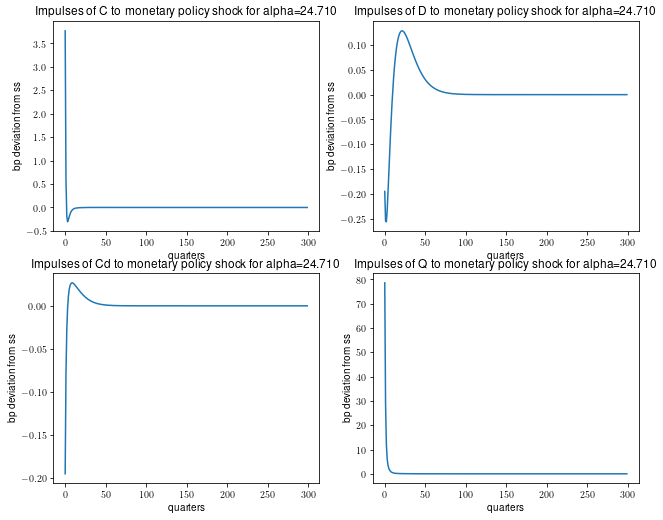

In [22]:
i = 15.0
name = 'alpha %1.3f' %i
alpha = alpha_grid[int(i)]

fig1 = plt.figure()
fig1.set_size_inches(10.5, 8.5)
ax1 = fig1.add_subplot(221)
ax1.plot(dC[name])
ax2 = fig1.add_subplot(222)
ax2.plot(dD[name])
ax3 = fig1.add_subplot(223)
ax3.plot(dCD[name])
ax4 = fig1.add_subplot(224)
ax4.plot(dQ[name])
ax1.title.set_text('Impulses of C to monetary policy shock for alpha=%1.3f' %alpha)
ax1.set_xlabel('quarters')
ax1.set_ylabel('bp deviation from ss')
ax2.title.set_text('Impulses of D to monetary policy shock for alpha=%1.3f' %alpha)
ax2.set_xlabel('quarters')
ax2.set_ylabel('bp deviation from ss')
ax3.title.set_text('Impulses of Cd to monetary policy shock for alpha=%1.3f' %alpha)
ax3.set_xlabel('quarters')
ax3.set_ylabel('bp deviation from ss')
ax4.title.set_text('Impulses of Q to monetary policy shock for alpha=%1.3f' %alpha)
ax4.set_xlabel('quarters')
ax4.set_ylabel('bp deviation from ss')
plt.show()
fig1.tight_layout(pad=7.0)